## Gaussian decomposable graphical model

Fitting a Gaussian decomposable graphical model to an auto-regressive G. 

In [13]:
SAVE_PLOTS = True
SAVE_LOC =  '/home/mo/src/decomposable_paper/img/CTA_gt13_'

In [14]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import trilearn
import trilearn.graph.junction_tree
import trilearn.graph.junction_tree as jtlib
import trilearn.graph.graph as glib
from trilearn.distributions import g_inv_wishart


import time
from scipy.interpolate import make_interp_spline
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
import parallelDG.mh_greenthomas as gt
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()
    
def smooth(x, y):
    if not x: 
        x = list(range(len(y)))
    X_Y_Spline = make_interp_spline(x, y, k=3)
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(np.min(x), np.max(x), 500)
    Y_ = X_Y_Spline(X_)
    return X_, Y_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulating CTA (0.5, 0.5) Gaussian graphical model

Christmas tree algorithm

In [15]:
p = 25
n = 200
alpha = 0.5
beta = 0.5
D = np.matrix(np.identity(p))  # Scale parameter
delta = 1.0

Number of edges 60, number of nodes 25
loglikelihood 5593.877251


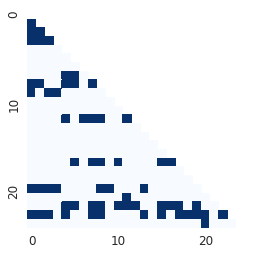

In [16]:
np.random.seed(3) # generates same data as in the paper
T = trilearn.graph.junction_tree.sample(p, alpha, beta)
G = jtlib.graph(T)
cov_mat = g_inv_wishart.sample(G, p, D)
cta_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), cov_mat, n))
aux.plot_heatmap(nx.to_numpy_array(G), xticklabels=10, yticklabels=10)
#nx.draw(G, with_labels=True)
print('Number of edges {}, number of nodes {}'.format(G.size(), G.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=cta_df,
                                                         graph=G,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
save_location('ggm_true_graph_adj')

No. Edges 60


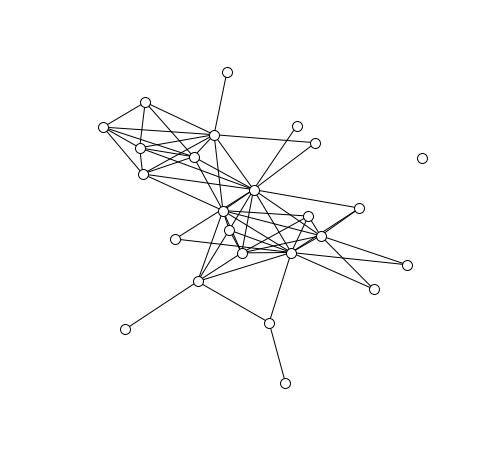

In [17]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(G, prog="fdp",)
nx.draw_networkx(G,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')
print('No. Edges {}'.format(G.number_of_edges()))

# Inference

## Green and Thomas (2013) sampler

In [19]:
n_samples = 1000000
burnin = 500000
randomize  = 100
delta = 1.0

In [20]:
tic = time.time()
traj =gt.sample_trajectory_ggm(dataframe=cta_df, 
                                n_samples=n_samples,
                                randomize=n_samples, 
                                delta = delta)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings samples: 100%|██████████| 999999/999999 [13:23<00:00, 1243.85it/s]

Time taken 804.02sec


### Graph number of edges

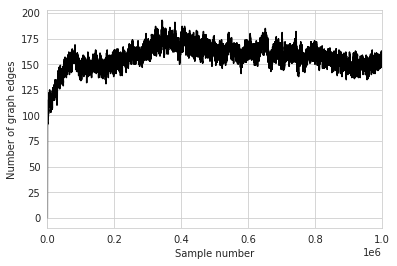

In [21]:
#traj._size=None
#traj.graph_updates = None
#traj.set_graph_trajectories()
traj.size().plot(color = 'black')
size_mcmc_index = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
#plt.ylim((50, 1000))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot')

### Progressive Acceptance ratio

In [23]:
## by mcmc index and subindex
## of the graph
acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)

Acceptance ratio 0.041773


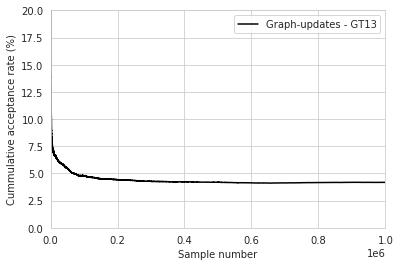

In [29]:
z = acc_mcmc_index[1] * 100
plt.plot(list(range(len(z))), z, color='black', label='Graph-updates - GT13')
plt.ylim((0, 20))
plt.xlim((0, len(z)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### Autocorrelation plot

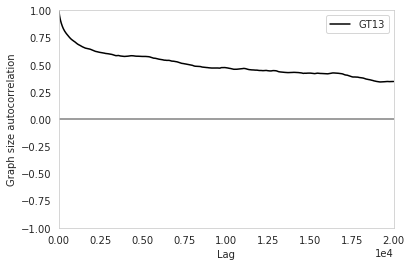

In [30]:
## Auto correlalation plot 
lag=20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'GT13', color = 'black', lag =lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')
#plt.show()

### Log-likelihood trace plot

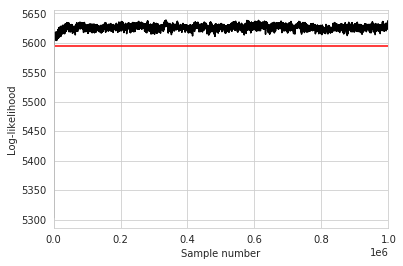

In [31]:
traj.log_likelihood().plot(color='black')
true_loglike= pdg.ggm_loglikelihood(dataframe=cta_df, 
                      graph=G,graph_prior=['uniform'],
                      delta=delta)
plt.axhline(y=true_loglike, 
            color='r', linestyle='-')  # Add a horizontal line at y=0
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
#plt.ylim((0, 1000))
save_location('ggm_loglikelihood_traceplot')

### Maximum A Posteriori Graph

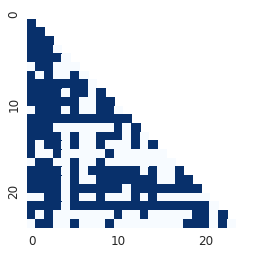

In [32]:
aux.plot_heatmap(nx.to_numpy_array(traj.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
save_location('ggm_est_map_graph')

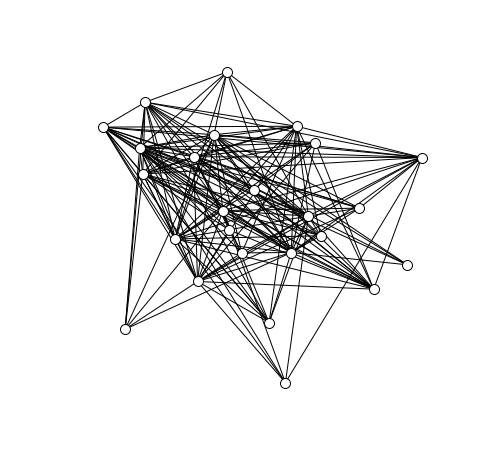

In [33]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Trace plot heatmap

In [34]:
emp=traj.empirical_distribution(burnin).heatmap()

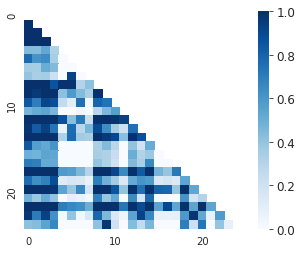

In [35]:
sns.set_style("whitegrid")
aux.plot_heatmap(emp, xticklabels=10, yticklabels=10 ,cbar = True)
save_location('ggm_est_heatmap')

### Most sampled graph

In [36]:
most_sampled = aux.most_sampled_graph(traj.trajectory[burnin:])
most_sampled

{'count': 269.0, 'g': <networkx.classes.graph.Graph at 0x7f930706fd90>}

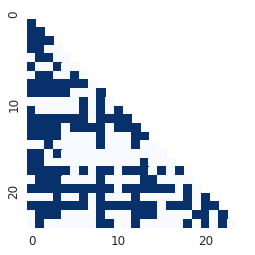

In [37]:
aux.plot_heatmap(nx.to_numpy_array(most_sampled['g']), xticklabels=10, yticklabels=10)
save_location('ggm_est_most_sampled_graph')

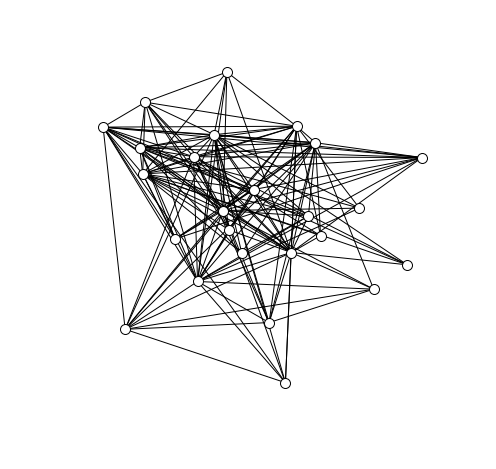

In [38]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(most_sampled['g'],pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()